# Mosaic dataset

This notebook creates mosaic dataset from FER-2013 dataset (https://www.kaggle.com/datasets/msambare/fer2013). We also do some EDA at the end of this notebook.

Step 1. Download FER-2013 data from https://www.kaggle.com/datasets/msambare/fer2013 . 

Step 2. Put FER-2013 dataset into Mosaic_data_folders/data/raw_data path. 

Step 3. Run this notebook. 

In [6]:
#!/usr/bin/env python3
# Balanced-emotion mosaics (400 images) with minimal reuse when needed.

import csv, json, random
from pathlib import Path
import numpy as np
from PIL import Image, ImageFilter, ImageOps, ImageDraw

# ------------------ CONFIG ------------------
INPUT_PATH  = "Mosaic_data_folders/data/raw_data/FER-2013/train"  
OUTDIR      = Path("Mosaic_data_folders/data/mosaic_data_balanced")
CANVAS_W, CANVAS_H = 1024, 683
PEOPLE_MIN, PEOPLE_MAX = 6, 18       # random people per mosaic
FACE_MIN, FACE_MAX = 48, 120
ROT_MAX_DEG = 10
MARGIN_EDGE = 8
MAX_IOU     = 0.20
COUNT       = 400                     # exactly 400 mosaics
SEED        = 2025
# --------------------------------------------

random.seed(SEED); np.random.seed(SEED)
OUTDIR.mkdir(parents=True, exist_ok=True); (OUTDIR/"images").mkdir(parents=True, exist_ok=True)
JSONL_PATH = OUTDIR/"annotations.jsonl"

CLASSES = ["Angry","Disgust","Fear","Happy","Sad","Surprised","Neutral"]
FER_IDX2NAME = {0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Sad",5:"Surprised",6:"Neutral"}
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

# ------------------ LOADERS ------------------
def norm_label(name:str)->str:
    n = name.strip().lower()
    if n=="surprise": n="surprised"
    if n=="disgusted": n="disgust"
    t = n.capitalize()
    return t if t in CLASSES else "Neutral"

def read_fer_csv(csv_path, subset="Training"):
    pools = {c: [] for c in CLASSES}
    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        for i,row in enumerate(csv.DictReader(f)):
            if row.get("Usage","")!=subset: continue
            pix = np.fromstring(row["pixels"], dtype=np.uint8, sep=" ")
            if pix.size!=48*48: continue
            img = Image.fromarray(pix.reshape(48,48), mode="L")
            lab = FER_IDX2NAME.get(int(row["emotion"]), "Neutral")
            pools[lab].append((img, lab, f"fercsv:{i}"))
    for c in CLASSES: random.shuffle(pools[c])
    return pools

def read_images_dir(root):
    pools = {c: [] for c in CLASSES}
    for p in Path(root).rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            try:
                pools[norm_label(p.parent.name)].append((Image.open(p).convert("L"),
                                                         norm_label(p.parent.name), str(p)))
            except Exception:
                pass
    for c in CLASSES: random.shuffle(pools[c])
    return pools

def load_pools(path):
    p=Path(path)
    if p.is_file(): return read_fer_csv(p)
    if p.is_dir():  return read_images_dir(p)
    raise FileNotFoundError(path)

# --------------- IMAGE HELPERS ---------------
def ellipse_mask(w,h,feather):
    y,x = np.ogrid[-1:1:complex(0,h), -1:1:complex(0,w)]
    r = np.sqrt(x*x + (y/0.9)*(y/0.9))
    m = np.clip(1.0 - r, 0, 1)
    return Image.fromarray((m*255).astype(np.uint8),"L").filter(ImageFilter.GaussianBlur(max(1,feather//2)))

def make_bg(W,H,base=210):
    bg = Image.new("L",(W,H),base)
    g  = Image.linear_gradient("L").resize((1,H)).resize((W,H))
    bg = Image.blend(bg, ImageOps.autocontrast(g,cutoff=2), 0.18)
    v  = Image.new("L",(W,H),0); d=ImageDraw.Draw(v)
    d.ellipse([-int(W*.2),-int(H*.2),int(W*1.2),int(H*1.2)], fill=255)
    v  = v.filter(ImageFilter.GaussianBlur(radius=min(W,H)//5))
    return Image.composite(bg, Image.new("L",(W,H),base-20), ImageOps.invert(v))

def iou(a,b):
    ax,ay,aw,ah=a; bx,by,bw,bh=b
    x1,y1=max(ax,bx),max(ay,by); x2,y2=min(ax+aw,bx+bw),min(ay+ah,by+bh)
    iw,ih=max(0,x2-x1),max(0,y2-y1); inter=iw*ih
    return 0.0 if inter==0 else inter/float(aw*ah + bw*bh - inter)

def try_place(existing, W,H, size, tries=120):
    for _ in range(tries):
        x = random.randint(MARGIN_EDGE, W - size - MARGIN_EDGE)
        y = random.randint(MARGIN_EDGE, H - size - MARGIN_EDGE)
        cand=[x,y,size,size]
        if all(iou(cand,b)<=MAX_IOU for b in existing): return cand
    return None

# --------------- BALANCED SAMPLER ---------------
def balanced_take(pools, k, reuse_log):
    """
    Take k faces with class balance (round-robin across CLASSES).
    Reuse minimal: if a class pool is empty, reuse by cycling from a shadow copy.
    `reuse_log` records how many times we had to reuse per class.
    Returns list of (img, label, source_id).
    """
    out = []
    # per-class iterators + shadow (for reuse)
    shadows = {c: pools[c][:] for c in CLASSES}  # copy for reuse fallback
    idx = 0
    while len(out) < k:
        c = CLASSES[idx % len(CLASSES)]
        if pools[c]:
            out.append(pools[c].pop())
        else:
            # reuse from shadow to keep global balance
            if not shadows[c]:
                # in case both empty (shouldn't happen), pick any available class
                avail = [cc for cc in CLASSES if pools[cc]]
                if avail:
                    out.append(pools[random.choice(avail)].pop())
                else:
                    # ultimate fallback: reuse any shadow
                    for cc in CLASSES:
                        if shadows[cc]:
                            out.append(shadows[cc][random.randrange(len(shadows[cc]))])
                            reuse_log[cc] += 1
                            break
            else:
                out.append(shadows[c][random.randrange(len(shadows[c]))])
                reuse_log[c] += 1
        idx += 1
    return out

# --------------- COMPOSE & WRITE ---------------
def compose_random(face_triplets, W,H):
    canvas = make_bg(W,H)
    placements=[]; placed=[]
    for imgL,label,src in face_triplets:
        side = random.randint(FACE_MIN, FACE_MAX)
        ang  = random.uniform(-ROT_MAX_DEG, ROT_MAX_DEG)
        f = imgL.resize((side,side), Image.BILINEAR).rotate(ang, expand=True)
        arr = np.array(f, np.float32)
        arr = np.clip(arr*np.random.uniform(0.97,1.05)+np.random.uniform(-2,2),0,255).astype(np.uint8)
        f = Image.fromarray(arr,"L")
        box_side = max(FACE_MIN, min(FACE_MAX, int(side*0.85)))
        spot = try_place(placed, W,H, box_side) or try_place(placed, W,H, max(FACE_MIN,int(box_side*0.85)))
        if not spot: continue
        x,y,bs,_=spot; cx,cy=x+bs//2, y+bs//2
        layer = Image.new("L",(W,H),0); px,py = cx-f.width//2, cy-f.height//2
        layer.paste(f,(px,py))
        mask = Image.new("L",(W,H),0); mask.paste(ellipse_mask(f.width,f.height,max(8,int(0.18*max(f.width,f.height)))),(px,py))
        canvas = Image.composite(layer, canvas, mask)
        placements.append({"bbox":[x,y,bs,bs], "label":label, "source_id":src})
        placed.append([x,y,bs,bs])

    arr = np.array(canvas,np.float32); arr = np.clip(arr+np.random.normal(0,1.2,arr.shape),0,255).astype(np.uint8)
    return Image.fromarray(arr,"L"), placements

def to_percent_boxes(placements, W,H):
    return [[(x/W)*100.0,(y/H)*100.0,(w/W)*100.0,(h/H)*100.0] for (x,y,w,h) in (p["bbox"] for p in placements)]

# -------------------- RUN --------------------
pools = load_pools(INPUT_PATH)  # dict: class -> list[(img, label, source_id)]
total_available = sum(len(v) for v in pools.values())
print("Available per class:", {k: len(v) for k,v in pools.items()})
print("Total available faces:", total_available)

reuse_log = {c: 0 for c in CLASSES}

with JSONL_PATH.open("w", encoding="utf-8") as jf:
    for idx in range(1, COUNT+1):
        n_people = random.randint(PEOPLE_MIN, PEOPLE_MAX)
        take = balanced_take(pools, n_people, reuse_log)
        img, placements = compose_random(take, CANVAS_W, CANVAS_H)
        fname = f"mosaic_{idx:05d}.png"
        img.save(OUTDIR/"images"/fname)

        obj = {
            "bbox": to_percent_boxes(placements, CANVAS_W, CANVAS_H),
            "categories": [p["label"] for p in placements],
            "source_paths": [p["source_id"] for p in placements],
            "original_width": CANVAS_W,
            "original_height": CANVAS_H,
            "image_file": f"images/{fname}"
        }
        jf.write(json.dumps(obj) + "\n")

print(f"Created {COUNT} mosaics in {OUTDIR/'images'}")
print(f" Wrote per-photo JSONL to {JSONL_PATH}")
print("  Minimal reuse counts (only when class pool empty):", reuse_log)


Available per class: {'Angry': 3995, 'Disgust': 436, 'Fear': 4097, 'Happy': 7215, 'Sad': 4830, 'Surprised': 3171, 'Neutral': 4965}
Total available faces: 28709
Created 400 mosaics in Mosaic_data_folders/data/mosaic_data_balanced/images
 Wrote per-photo JSONL to Mosaic_data_folders/data/mosaic_data_balanced/annotations.jsonl
  Minimal reuse counts (only when class pool empty): {'Angry': 0, 'Disgust': 0, 'Fear': 0, 'Happy': 0, 'Sad': 0, 'Surprised': 0, 'Neutral': 0}


✅ Loaded 4860 faces across 400 photos

People per photo:
count    400.000000
mean      12.150000
std        3.731261
min        6.000000
25%        9.000000
50%       12.000000
75%       15.000000
max       18.000000
Name: emotion, dtype: float64

Emotion distribution:
emotion
Angry        939
Fear         795
Happy        765
Sad          668
Surprised    659
Neutral      598
Disgust      436
Name: count, dtype: int64


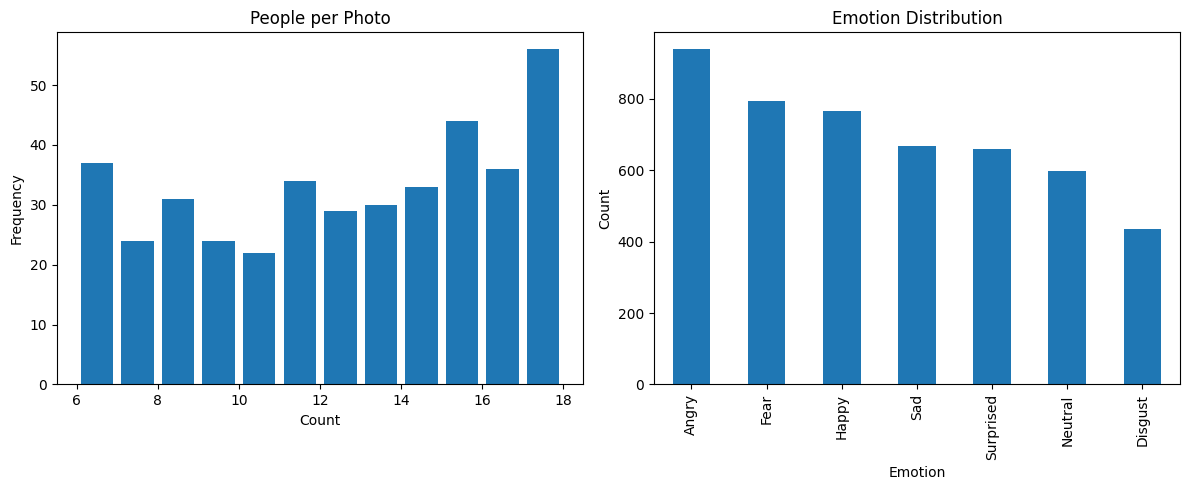

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ---- parameters ----
JSONL = "Mosaic_data_folders/data/mosaic_data_balanced/annotations.jsonl"  # path to your JSONL file
# --------------------

# Load JSONL into list of dicts
records = []
with open(JSONL, "r") as f:
    for line in f:
        if not line.strip():
            continue
        data = json.loads(line)
        n_faces = len(data["categories"])
        for box, label in zip(data["bbox"], data["categories"]):
            records.append({
                "image_file": data.get("image_file", ""),
                "emotion": label,
                "x_pct": box[0],
                "y_pct": box[1],
                "w_pct": box[2],
                "h_pct": box[3],
                "img_width": data["original_width"],
                "img_height": data["original_height"],
                "people_in_photo": n_faces
            })

df = pd.DataFrame(records)
print(f"✅ Loaded {df.shape[0]} faces across {df['image_file'].nunique()} photos")

# ---- Summary stats ----
print("\nPeople per photo:")
print(df.groupby("image_file")["emotion"].count().describe())

print("\nEmotion distribution:")
print(df["emotion"].value_counts())

# ---- Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Histogram: people per photo
df.groupby("image_file")["emotion"].count().plot.hist(
    bins=range(df["people_in_photo"].min(), df["people_in_photo"].max()+1),
    ax=axes[0],
    rwidth=0.8
)
axes[0].set_title("People per Photo")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Frequency")

# Bar: emotion counts
df["emotion"].value_counts().plot.bar(ax=axes[1])
axes[1].set_title("Emotion Distribution")
axes[1].set_xlabel("Emotion")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [10]:
from pathlib import Path
from collections import Counter
import json

JSONL = Path("Mosaic_data_folders/data/mosaic_data_balanced/annotations.jsonl")  # adjust if needed

counts = Counter()
num_photos = 0
num_faces  = 0

with JSONL.open("r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        rec = json.loads(line)
        cats = rec.get("categories", [])
        counts.update(cats)
        num_photos += 1
        num_faces  += len(cats)

print(f"Photos: {num_photos}")
print(f"Total faces: {num_faces}\n")

total = sum(counts.values()) or 1
print("Emotion distribution (count, percent):")
for emotion, cnt in counts.most_common():
    print(f"{emotion:10s}  {cnt:5d}  ({cnt/total:.1%})")


Photos: 400
Total faces: 4860

Emotion distribution (count, percent):
Angry         939  (19.3%)
Fear          795  (16.4%)
Happy         765  (15.7%)
Sad           668  (13.7%)
Surprised     659  (13.6%)
Neutral       598  (12.3%)
Disgust       436  (9.0%)


In [1]:
import json, csv
from pathlib import Path

# ---- set your input JSONL ----
JSONL = Path("Mosaic_data_folders/data/mosaic_data_balanced/annotations.jsonl")

# output CSV path (same folder)
OUT_CSV = JSONL.with_name("mosaic_photos.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

rows = []
with JSONL.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rec = json.loads(line)
        rows.append({
            "image_file": rec.get("image_file", ""),
            "original_width": rec.get("original_width", ""),
            "original_height": rec.get("original_height", ""),
            "people_count": len(rec.get("categories", [])),
            # store lists as JSON strings to keep one-row-per-photo
            "categories": json.dumps(rec.get("categories", []), ensure_ascii=False),
            "bbox": json.dumps(rec.get("bbox", []), ensure_ascii=False),
            "source_paths": json.dumps(rec.get("source_paths", []), ensure_ascii=False),
        })

# write CSV (one row per mosaic)
with OUT_CSV.open("w", newline="", encoding="utf-8") as f:
    fieldnames = ["image_file","original_width","original_height","people_count",
                  "categories","bbox","source_paths"]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

print(f"✅ Wrote {len(rows)} rows to {OUT_CSV}")


✅ Wrote 400 rows to Mosaic_data_folders/data/mosaic_data_balanced/mosaic_photos.csv


In [5]:
OUTDIR = "Mosaic_data_folders/data/mosaic_data_balanced"
JSONL = f"{OUTDIR}/annotations.jsonl"

import json, random
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Markdown

def load_jsonl(path):
    with open(path, "r") as f:
        for line in f:
            if line.strip():
                yield json.loads(line)

def pct_to_px(box_pct, W, H):
    x_pct, y_pct, w_pct, h_pct = box_pct
    return (x_pct/100.0)*W, (y_pct/100.0)*H, (w_pct/100.0)*W, (h_pct/100.0)*H

def overlay(img_path, record, color=(255, 60, 60)):
    img = Image.open(img_path).convert("RGB")
    W, H = img.size
    draw = ImageDraw.Draw(img)

    # Try to load a default font (fallback to PIL's builtin)
    try:
        font = ImageFont.load_default()
    except:
        font = None

    for box_pct, label in zip(record["bbox"], record["categories"]):
        x, y, w, h = pct_to_px(box_pct, W, H)
        x2, y2 = x + w, y + h

        # box
        draw.rectangle([x, y, x2, y2], outline=color, width=3)

        # label tag
        tag = f"{label}"
        tw, th = draw.textbbox((0,0), tag, font=font)[2:]
        pad = 4
        bg = [x, max(0, y - th - 2*pad), x + tw + 2*pad, y]
        draw.rectangle(bg, fill=(0,0,0))
        draw.text((x + pad, bg[1] + pad), tag, fill=(255,255,255), font=font)

    return img

# ---- preview N random samples ----
N = 0  # how many to preview
records = list(load_jsonl(JSONL))
random.shuffle(records)
sample = records[:N]

for rec in sample:
    img_path = Path(OUTDIR) / rec.get("image_file", "")
    display(Markdown(f"**Image:** `{rec.get('image_file','')}`  —  "
                     f"size: {rec['original_width']}×{rec['original_height']}  —  "
                     f"faces: {len(rec['bbox'])}"))
    display(overlay(img_path, rec))


In [ ]:
from pathlib import Path
from collections import Counter, defaultdict

ROOT = Path("Mosaic_data_folders/data/raw_data/FER-2013")

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
FER_CLASSES = ["Angry","Disgust","Fear","Happy","Sad","Surprised","Neutral"]
FER_SET = set(FER_CLASSES)

def norm_label(name: str) -> str:
    n = name.strip().lower()
    if n == "surprise": n = "surprised"
    if n == "disgusted": n = "disgust"
    lab = n.capitalize()
    return lab if lab in FER_SET else None  # ignore unknown folders

def is_split_folder(p: Path) -> bool:
    return p.name.lower() in {"train","training","publictest","privatetest","val","valid","validation","test"}

def count_split(split_root: Path) -> Counter:
    """Count images by normalized label under split_root/<label>/*"""
    c = Counter()
    for lab_dir in split_root.iterdir():
        if not lab_dir.is_dir():
            continue
        lab = norm_label(lab_dir.name)
        if not lab:
            continue
        # count files with valid image extensions
        for img in lab_dir.rglob("*"):
            if img.suffix.lower() in IMG_EXTS:
                c[lab] += 1
    return c

def format_counts(c: Counter) -> str:
    total = sum(c.values()) or 1
    lines = []
    for k in FER_CLASSES:
        v = c.get(k, 0)
        lines.append(f"{k:10s} {v:6d}  ({v/total:6.2%})")
    lines.append(f"{'-'*22}\nTOTAL       {total:6d}  (100.00%)")
    return "\n".join(lines)

# Detect if ROOT itself is a split (has emotion folders) or contains multiple splits
splits = []
if any((ROOT / d).is_dir() and norm_label(d) for d in [p.name for p in ROOT.iterdir() if p.is_dir()]):
    # ROOT directly has emotion folders
    splits = [(ROOT.name, ROOT)]
else:
    # look for known split folders beneath ROOT
    for p in ROOT.iterdir():
        if p.is_dir() and is_split_folder(p):
            splits.append((p.name, p))
    # fallback: if none matched, treat every subfolder as a split
    if not splits:
        splits = [(p.name, p) for p in ROOT.iterdir() if p.is_dir()]

overall = Counter()
for split_name, split_root in splits:
    c = count_split(split_root)
    overall.update(c)
    print(f"\n== {split_name} ==")
    print(format_counts(c))

print("\n== OVERALL ==")
print(format_counts(overall))



== test ==
Angry         958  (13.35%)
Disgust       111  ( 1.55%)
Fear         1024  (14.27%)
Happy        1774  (24.71%)
Sad          1247  (17.37%)
Surprised     831  (11.58%)
Neutral      1233  (17.18%)
----------------------
TOTAL         7178  (100.00%)

== train ==
Angry        3995  (13.92%)
Disgust       436  ( 1.52%)
Fear         4097  (14.27%)
Happy        7215  (25.13%)
Sad          4830  (16.82%)
Surprised    3171  (11.05%)
Neutral      4965  (17.29%)
----------------------
TOTAL        28709  (100.00%)

== OVERALL ==
Angry        4953  (13.80%)
Disgust       547  ( 1.52%)
Fear         5121  (14.27%)
Happy        8989  (25.05%)
Sad          6077  (16.93%)
Surprised    4002  (11.15%)
Neutral      6198  (17.27%)
----------------------
TOTAL        35887  (100.00%)
